# This notebook will read in .txt files of betting odds for the last 7 years of NBA games, analyze them and prepare them for ML

In [376]:
import os
import pandas as pd
import numpy as np
import datetime
import re
import inspect

from sklearnex import patch_sklearn
patch_sklearn()

import sklearn
import optuna
import xgboost as xgb

import shap
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

from itertools import chain
from pandas_profiling import ProfileReport
from boruta import BorutaPy
from imblearn.over_sampling import ADASYN
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import FeatureHasher

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier,
    StackingClassifier
)

from sklearn.model_selection import (
    train_test_split,
    RepeatedKFold,
    cross_validate, 
    cross_val_score
)

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder,
    PowerTransformer,
    MinMaxScaler
)

from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    recall_score, 
    precision_score, 
    f1_score,
    cohen_kappa_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [377]:
files = [filename for filename in os.listdir('Data') if os.path.isdir(os.path.join('Data',filename))]
odds = []
scores = []
for file in files:
    temp_odds = pd.read_csv('Data/'+file+'/vegas.txt',index_col=0,parse_dates=True)
    temp_scores = pd.read_csv('Data/'+file+'/raw_scores.txt',index_col=0,parse_dates=True)
    odds.append(temp_odds)
    scores.append(temp_scores)
master_odds = pd.concat(odds,axis=0)
master_scores = pd.concat(scores,axis=0)

In [378]:
display(master_odds)
master_odds.index = pd.to_datetime(master_odds.index)

,Location,Team,OppTeam,TeamId,GameId,PercentBet_ML,Open_Line_ML,Pinnacle_ML,5dimes_ML,Heritage_ML,...,Average_Line_OU,Average_Odds_OU,Best_Line_OU,Worst_Line_OU,Best_Odds_OU,Worst_Odds_OU,Pts,Spread,Result,Total
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-17,away,Boston,Cleveland,1610612738,21700001,50.4,150.0,166.0,170.0,165.0,...,216.17,-106.83,216.5,216.0,-101.0,-110.0,99.0,-3.0,L,201.0
2017-10-17,home,Cleveland,Boston,1610612739,21700001,49.6,-170.0,-185.0,-185.0,-190.0,...,216.17,-108.17,216.5,216.0,-105.0,-110.0,102.0,3.0,W,201.0
2017-10-17,away,Houston,Golden State,1610612745,21700002,52.7,405.0,377.0,420.0,390.0,...,231.75,-109.67,235.0,230.5,-103.0,-115.0,122.0,1.0,W,243.0
2017-10-17,home,Golden State,Houston,1610612744,21700002,47.3,-500.0,-440.0,-475.0,-515.0,...,231.75,-105.33,235.0,230.5,-100.0,-110.0,121.0,-1.0,L,243.0
2017-10-18,away,Charlotte,Detroit,1610612766,21700003,51.3,130.0,127.0,130.0,125.0,...,202.17,-107.83,203.0,202.0,-102.0,-115.0,90.0,-12.0,L,192.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-13,home,L.A. Lakers,Utah,1610612747,21501228,95.0,195.0,153.0,150.0,145.0,...,195.08,-107.17,196.5,189.5,-103.0,-110.0,101.0,5.0,W,197.0
2016-04-13,away,L.A. Clippers,Phoenix,1610612746,21501229,65.3,175.0,166.0,170.0,180.0,...,205.33,-109.83,206.0,203.5,-105.0,-115.0,105.0,-9.0,L,219.0
2016-04-13,home,Phoenix,L.A. Clippers,1610612756,21501229,34.7,-205.0,-185.0,-200.0,-210.0,...,205.33,-106.83,206.0,203.5,-101.0,-110.0,114.0,9.0,W,219.0


In [379]:
master_scores.columns

Index(['GAME_SEQUENCE', 'GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'TEAM_CITY_NAME', 'TEAM_WINS_LOSSES', 'PTS_QTR1', 'PTS_QTR2',
       'PTS_QTR3', 'PTS_QTR4', 'PTS_OT1', 'PTS_OT2', 'PTS_OT3', 'PTS_OT4',
       'PTS_OT5', 'PTS_OT6', 'PTS_OT7', 'PTS_OT8', 'PTS_OT9', 'PTS_OT10',
       'PTS', 'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB', 'TOV'],
      dtype='object')

In [380]:
master_odds = master_odds[[
       'Location', 'Team', 'OppTeam', 'TeamId', 'GameId', 'PercentBet_OU', 'Open_Line_OU', 'Open_Odds_OU',
       'Pinnacle_Line_OU', 'Pinnacle_Odds_OU', '5dimes_Line_OU',
       '5dimes_Odds_OU', 'Heritage_Line_OU', 'Heritage_Odds_OU',
       'Bovada_Line_OU', 'Bovada_Odds_OU', 'Betonline_Line_OU',
       'Betonline_Odds_OU', 'Average_Line_OU', 'Average_Odds_OU',
       'Best_Line_OU', 'Worst_Line_OU', 'Best_Odds_OU', 'Worst_Odds_OU',
       'Result', 'Total'
    ]]

In [381]:
master_odds.dtypes

Location              object
Team                  object
OppTeam               object
TeamId                 int64
GameId                 int64
PercentBet_OU        float64
Open_Line_OU         float64
Open_Odds_OU         float64
Pinnacle_Line_OU     float64
Pinnacle_Odds_OU     float64
5dimes_Line_OU       float64
5dimes_Odds_OU       float64
Heritage_Line_OU     float64
Heritage_Odds_OU     float64
Bovada_Line_OU       float64
Bovada_Odds_OU       float64
Betonline_Line_OU    float64
Betonline_Odds_OU    float64
Average_Line_OU      float64
Average_Odds_OU      float64
Best_Line_OU         float64
Worst_Line_OU        float64
Best_Odds_OU         float64
Worst_Odds_OU        float64
Result                object
Total                float64
dtype: object

In [382]:
master_odds_away = master_odds[master_odds['Location'] == 'away']
master_odds_home = master_odds[master_odds['Location'] == 'home']
display(master_odds_away.head(20))
display(master_odds_home.head(20))

,Location,Team,OppTeam,TeamId,GameId,PercentBet_OU,Open_Line_OU,Open_Odds_OU,Pinnacle_Line_OU,Pinnacle_Odds_OU,...,Betonline_Line_OU,Betonline_Odds_OU,Average_Line_OU,Average_Odds_OU,Best_Line_OU,Worst_Line_OU,Best_Odds_OU,Worst_Odds_OU,Result,Total
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-17,away,Boston,Cleveland,1610612738,21700001,47.0,216.5,-110.0,216.5,-101.0,...,216.0,-110.0,216.17,-106.83,216.5,216.0,-101.0,-110.0,L,201.0
2017-10-17,away,Houston,Golden State,1610612745,21700002,43.1,235.0,-110.0,230.5,-110.0,...,230.5,-115.0,231.75,-109.67,235.0,230.5,-103.0,-115.0,W,243.0
2017-10-18,away,Charlotte,Detroit,1610612766,21700003,42.9,203.0,-110.0,202.0,-105.0,...,202.0,-115.0,202.17,-107.83,203.0,202.0,-102.0,-115.0,L,192.0
2017-10-18,away,Brooklyn,Indiana,1610612751,21700004,0.0,212.5,-110.0,216.5,-110.0,...,217.0,-105.0,216.00,-108.00,217.0,212.5,-105.0,-110.0,L,271.0
2017-10-18,away,Miami,Orlando,1610612748,21700005,0.0,207.0,-110.0,205.5,-103.0,...,205.5,-110.0,205.67,-108.33,207.0,205.0,-103.0,-115.0,L,225.0
2017-10-18,away,Philadelphia,Washington,1610612755,21700006,62.1,215.0,-110.0,218.0,-104.0,...,217.5,-115.0,217.42,-107.83,218.0,215.0,-103.0,-115.0,L,235.0
2017-10-18,away,Milwaukee,Boston,1610612749,21700007,58.6,209.5,-110.0,203.5,-103.0,...,204.0,-100.0,204.50,-105.17,209.5,203.0,-100.0,-110.0,W,208.0
2017-10-18,away,New Orleans,Memphis,1610612740,21700008,0.0,204.0,-110.0,204.5,-104.0,...,204.5,-110.0,204.42,-108.17,205.0,204.0,-104.0,-115.0,L,194.0
2017-10-18,away,Atlanta,Dallas,1610612737,21700009,8.3,200.0,-110.0,198.5,-109.0,...,199.0,-110.0,199.08,-107.67,200.0,198.5,-102.0,-110.0,W,228.0


,Location,Team,OppTeam,TeamId,GameId,PercentBet_OU,Open_Line_OU,Open_Odds_OU,Pinnacle_Line_OU,Pinnacle_Odds_OU,...,Betonline_Line_OU,Betonline_Odds_OU,Average_Line_OU,Average_Odds_OU,Best_Line_OU,Worst_Line_OU,Best_Odds_OU,Worst_Odds_OU,Result,Total
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-17,home,Cleveland,Boston,1610612739,21700001,53.0,216.5,-110.0,216.5,-109.0,...,216.0,-110.0,216.17,-108.17,216.5,216.0,-105.0,-110.0,W,201.0
2017-10-17,home,Golden State,Houston,1610612744,21700002,56.9,235.0,-110.0,230.5,-100.0,...,230.5,-105.0,231.75,-105.33,235.0,230.5,-100.0,-110.0,L,243.0
2017-10-18,home,Detroit,Charlotte,1610612765,21700003,57.1,203.0,-110.0,202.0,-105.0,...,202.0,-105.0,202.17,-107.17,203.0,202.0,-105.0,-110.0,W,192.0
2017-10-18,home,Indiana,Brooklyn,1610612754,21700004,100.0,212.5,-110.0,216.5,-100.0,...,217.0,-115.0,216.00,-107.00,217.0,212.5,-100.0,-115.0,W,271.0
2017-10-18,home,Orlando,Miami,1610612753,21700005,100.0,207.0,-110.0,205.5,-107.0,...,205.5,-110.0,205.67,-106.67,207.0,205.0,-103.0,-110.0,W,225.0
2017-10-18,home,Washington,Philadelphia,1610612764,21700006,37.9,215.0,-110.0,218.0,-106.0,...,217.5,-105.0,217.42,-107.17,218.0,215.0,-105.0,-110.0,W,235.0
2017-10-18,home,Boston,Milwaukee,1610612738,21700007,41.4,209.5,-110.0,203.5,-107.0,...,204.0,-120.0,204.50,-109.83,209.5,203.0,-102.0,-120.0,L,208.0
2017-10-18,home,Memphis,New Orleans,1610612763,21700008,100.0,204.0,-110.0,204.5,-106.0,...,204.5,-110.0,204.42,-106.83,205.0,204.0,-105.0,-110.0,W,194.0
2017-10-18,home,Dallas,Atlanta,1610612742,21700009,91.7,200.0,-110.0,198.5,-101.0,...,199.0,-110.0,199.08,-107.33,200.0,198.5,-101.0,-110.0,L,228.0


In [383]:
team_name_dict = {}
team_name_dict1 = master_odds_away.set_index('TeamId').to_dict()['Team']
for key,value in team_name_dict1.items():
    if value not in team_name_dict.values():
        team_name_dict[key] = value
team_name_dict = {y: x for x, y in team_name_dict.items()}


In [384]:
team_name_dict

{'Boston': 1610612738,
 'Houston': 1610612745,
 'Charlotte': 1610612766,
 'Brooklyn': 1610612751,
 'Miami': 1610612748,
 'Philadelphia': 1610612755,
 'Milwaukee': 1610612749,
 'New Orleans': 1610612740,
 'Atlanta': 1610612737,
 'Denver': 1610612743,
 'Minnesota': 1610612750,
 'Portland': 1610612757,
 'Chicago': 1610612741,
 'New York': 1610612752,
 'L.A. Clippers': 1610612746,
 'Detroit': 1610612765,
 'Cleveland': 1610612739,
 'Orlando': 1610612753,
 'Utah': 1610612762,
 'Sacramento': 1610612758,
 'Golden State': 1610612744,
 'L.A. Lakers': 1610612747,
 'Indiana': 1610612754,
 'San Antonio': 1610612759,
 'Dallas': 1610612742,
 'Oklahoma City': 1610612760,
 'Phoenix': 1610612756,
 'Memphis': 1610612763,
 'Toronto': 1610612761,
 'Washington': 1610612764}

In [385]:
master_odds_home.drop(columns=['Location', 'Team'], inplace=True)
master_odds_home =  master_odds_home.rename(columns={
    'OppTeam': 'away_team_id',
    'TeamId' : 'home_team_id',
    'Result' : 'home_team_result',
    'GameId' : 'game_id'

})


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [386]:
master_odds_home1 = master_odds_home.replace({'away_team_id': team_name_dict})
master_odds_home1['away_team_id'] = master_odds_home1['away_team_id'].astype('int64')
master_odds_home1['home_team_result'].replace({
    'W' : 1,
    'L' : 0
},inplace=True)


In [387]:
display(master_odds_home1)

,away_team_id,home_team_id,game_id,PercentBet_OU,Open_Line_OU,Open_Odds_OU,Pinnacle_Line_OU,Pinnacle_Odds_OU,5dimes_Line_OU,5dimes_Odds_OU,...,Betonline_Line_OU,Betonline_Odds_OU,Average_Line_OU,Average_Odds_OU,Best_Line_OU,Worst_Line_OU,Best_Odds_OU,Worst_Odds_OU,home_team_result,Total
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-17,1610612738,1610612739,21700001,53.0,216.5,-110.0,216.5,-109.0,216.0,-105.0,...,216.0,-110.0,216.17,-108.17,216.5,216.0,-105.0,-110.0,1,201.0
2017-10-17,1610612745,1610612744,21700002,56.9,235.0,-110.0,230.5,-100.0,231.0,-107.0,...,230.5,-105.0,231.75,-105.33,235.0,230.5,-100.0,-110.0,0,243.0
2017-10-18,1610612766,1610612765,21700003,57.1,203.0,-110.0,202.0,-105.0,202.0,-108.0,...,202.0,-105.0,202.17,-107.17,203.0,202.0,-105.0,-110.0,1,192.0
2017-10-18,1610612751,1610612754,21700004,100.0,212.5,-110.0,216.5,-100.0,216.5,-102.0,...,217.0,-115.0,216.00,-107.00,217.0,212.5,-100.0,-115.0,1,271.0
2017-10-18,1610612748,1610612753,21700005,100.0,207.0,-110.0,205.5,-107.0,205.5,-103.0,...,205.5,-110.0,205.67,-106.67,207.0,205.0,-103.0,-110.0,1,225.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-13,1610612740,1610612750,21501226,41.6,213.0,-110.0,212.0,-100.0,212.5,-110.0,...,212.5,-110.0,212.67,-107.50,213.0,212.0,-100.0,-110.0,1,253.0
2016-04-13,1610612763,1610612744,21501227,56.6,211.5,-110.0,213.5,-105.0,213.0,-110.0,...,213.0,-110.0,213.08,-109.17,214.0,211.5,-105.0,-115.0,1,229.0
2016-04-13,1610612762,1610612747,21501228,38.8,189.5,-110.0,196.0,-103.0,196.0,-110.0,...,196.5,-110.0,195.08,-107.17,196.5,189.5,-103.0,-110.0,1,197.0


In [388]:
master_odds_home1.dtypes

away_team_id           int64
home_team_id           int64
game_id                int64
PercentBet_OU        float64
Open_Line_OU         float64
Open_Odds_OU         float64
Pinnacle_Line_OU     float64
Pinnacle_Odds_OU     float64
5dimes_Line_OU       float64
5dimes_Odds_OU       float64
Heritage_Line_OU     float64
Heritage_Odds_OU     float64
Bovada_Line_OU       float64
Bovada_Odds_OU       float64
Betonline_Line_OU    float64
Betonline_Odds_OU    float64
Average_Line_OU      float64
Average_Odds_OU      float64
Best_Line_OU         float64
Worst_Line_OU        float64
Best_Odds_OU         float64
Worst_Odds_OU        float64
home_team_result       int64
Total                float64
dtype: object

Text(0, 0.5, 'Total Points scored')

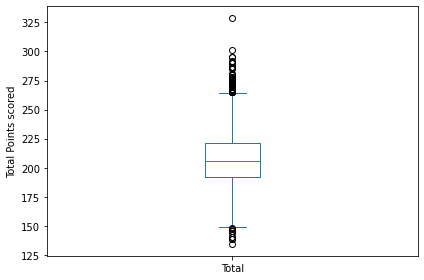

In [389]:
ax = (master_odds_home1['Total'].plot.box())
ax.set_ylabel('Total Points scored')

plt.tight_layout()
plt.show()

Text(0.5, 0, 'Total)')

Text(0, 0.5, 'Average Line O/U')

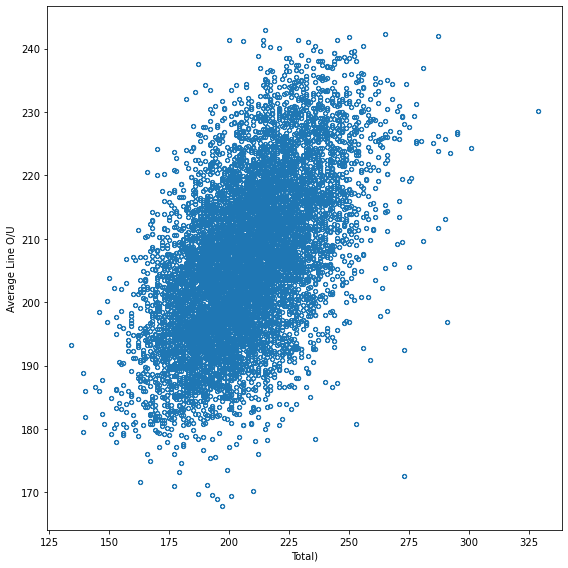

In [394]:
ax = master_odds_home1.plot.scatter(x='Total', y='Average_Line_OU', figsize=(8, 8), marker='$\u25EF$')
ax.set_xlabel('Total)')
ax.set_ylabel('Average Line O/U')

plt.tight_layout()
plt.show()

Text(0.5, 0, 'Total Points Scored')

Text(0, 0.5, 'Average Line O/U')

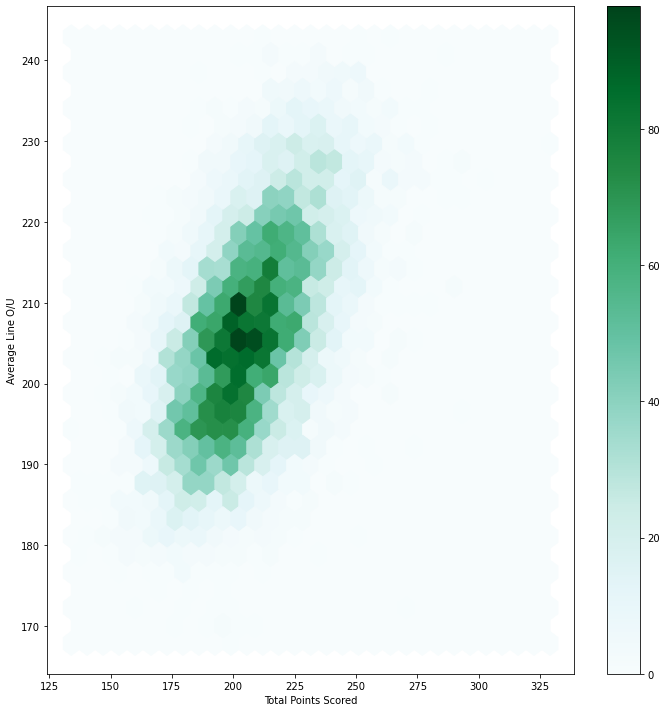

In [396]:
ax = master_odds_home1.plot.hexbin(x='Total', y='Average_Line_OU',
                         gridsize=30, sharex=False, figsize=(10,10))
ax.set_xlabel('Total Points Scored')
ax.set_ylabel('Average Line O/U')

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Total', ylabel='Average_Line_OU'>

Text(0.5, 0, 'Total Points Scored')

Text(0, 0.5, 'Average O/U Line')

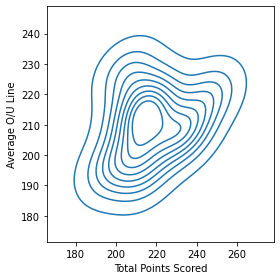

In [400]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.kdeplot(data=master_odds_home1.sample(10), x='Total', y='Average_Line_OU', ax=ax)
ax.set_xlabel('Total Points Scored')
ax.set_ylabel('Average O/U Line')

plt.tight_layout()
plt.show()